In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torch
import torchvision
import torch.nn as nn
import time
import copy

from glob import glob
from torchvision import transforms, models, datasets
from torch.autograd import Variable
from torch import optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

%matplotlib inline

In [7]:
# CUDA GPU availability
torch.cuda.is_available()

True

In [8]:
# validate dataset folder directory
# mount drive first (ONLY MALIK)

dir = 'D:/kampus/S2/Deep learning/Vegetable Images/Vegetable Images'

print(os.listdir('D:/kampus/S2/Deep learning/Vegetable Images/Vegetable Images'))
print(os.listdir('D:/kampus/S2/Deep learning/Vegetable Images/Vegetable Images/train'))
print(os.listdir('D:/kampus/S2/Deep learning/Vegetable Images/Vegetable Images/test'))
print(os.listdir('D:/kampus/S2/Deep learning/Vegetable Images/Vegetable Images/validation'))

['test', 'train', 'validation']
['Carrot', 'Papaya', 'Potato']
['Carrot', 'Papaya', 'Potato']
['Carrot', 'Papaya', 'Potato']


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation and test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
img_datasets = {x: datasets.ImageFolder(os.path.join(dir, x),
                                        data_transforms[x])
                for x in ['train', 'test', 'validation']}

data_loaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=6,
                                               shuffle=True, num_workers=2)
                for x in ['train', 'test', 'validation']}

datasets_size = {x: len(img_datasets[x]) for x in ['train', 'test', 'validation']}

class_names = img_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# visualize img dataset

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

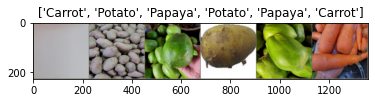

In [12]:
inputs, classes = next(iter(data_loaders['train']))
grid = torchvision.utils.make_grid(inputs)

imshow(grid, title=[class_names[x] for x in classes])

In [13]:
# generic function for training model
# schedulling lr and saving best model

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasets_size[phase]
            epoch_acc = running_corrects.double() / datasets_size[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# Generic function to display predictions for a few images

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
# call the pretrained architecture

model_ft_pretrained = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model_ft_pretrained.fc.in_features

model_ft_pretrained.fc = nn.Linear(num_ftrs, 3)

model_ft_pretrained = model_ft_pretrained.to(device)

In [16]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_pretrained.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
# train and evaluate model

model_ft_pretrained = train_model(model_ft_pretrained, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1924 Acc: 0.9293
validation Loss: 0.0035 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.0940 Acc: 0.9717
validation Loss: 0.0039 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.0802 Acc: 0.9750
validation Loss: 0.0011 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.0502 Acc: 0.9853
validation Loss: 0.0014 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0425 Acc: 0.9887
validation Loss: 0.0015 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.0289 Acc: 0.9917
validation Loss: 0.0017 Acc: 0.9983

Epoch 6/9
----------
train Loss: 0.0426 Acc: 0.9873
validation Loss: 0.0006 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.0178 Acc: 0.9950
validation Loss: 0.0003 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0126 Acc: 0.9967
validation Loss: 0.0002 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0280 Acc: 0.9933
validation Loss: 0.0001 Acc: 1.0000

Training complete in 5m 41s
Best val Acc: 1.000000


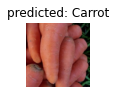

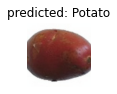

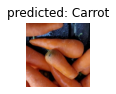

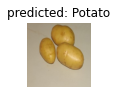

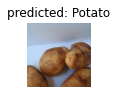

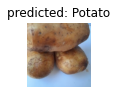

In [18]:
visualize_model(model_ft_pretrained)

In [19]:
# call the architecture for training from scratch

model_ft_sc = models.resnet18(weights=None)
num_ftrs = model_ft_sc.fc.in_features

model_ft_sc.fc = nn.Linear(num_ftrs, 3)

model_ft_sc = model_ft_sc.to(device)

In [20]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_sc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
# train and evaluate model

model_ft_sc = train_model(model_ft_sc, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4273 Acc: 0.8390
validation Loss: 0.2152 Acc: 0.9367

Epoch 1/9
----------
train Loss: 0.2875 Acc: 0.8973
validation Loss: 0.0322 Acc: 0.9933

Epoch 2/9
----------
train Loss: 0.2473 Acc: 0.9167
validation Loss: 0.0232 Acc: 0.9967

Epoch 3/9
----------
train Loss: 0.2008 Acc: 0.9337
validation Loss: 0.0200 Acc: 0.9983

Epoch 4/9
----------
train Loss: 0.1299 Acc: 0.9543
validation Loss: 0.0098 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.1581 Acc: 0.9530
validation Loss: 0.0256 Acc: 0.9950

Epoch 6/9
----------
train Loss: 0.1241 Acc: 0.9577
validation Loss: 0.0241 Acc: 0.9950

Epoch 7/9
----------
train Loss: 0.0759 Acc: 0.9753
validation Loss: 0.0081 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.0780 Acc: 0.9803
validation Loss: 0.0059 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0688 Acc: 0.9803
validation Loss: 0.0052 Acc: 1.0000

Training complete in 5m 25s
Best val Acc: 1.000000


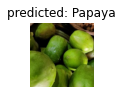

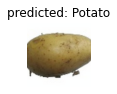

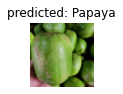

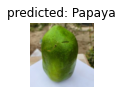

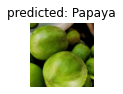

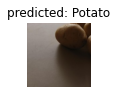

In [22]:
visualize_model(model_ft_sc)